In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [61]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
sample=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [62]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
train=train.drop(['Ticket', 'Cabin'], axis=1)
test=test.drop(['Ticket', 'Cabin'], axis=1)

### 1. Outlier detections
We can use various visualization methods, like BoxPlot, histogram, ScatterPlot to detect the outlier points.

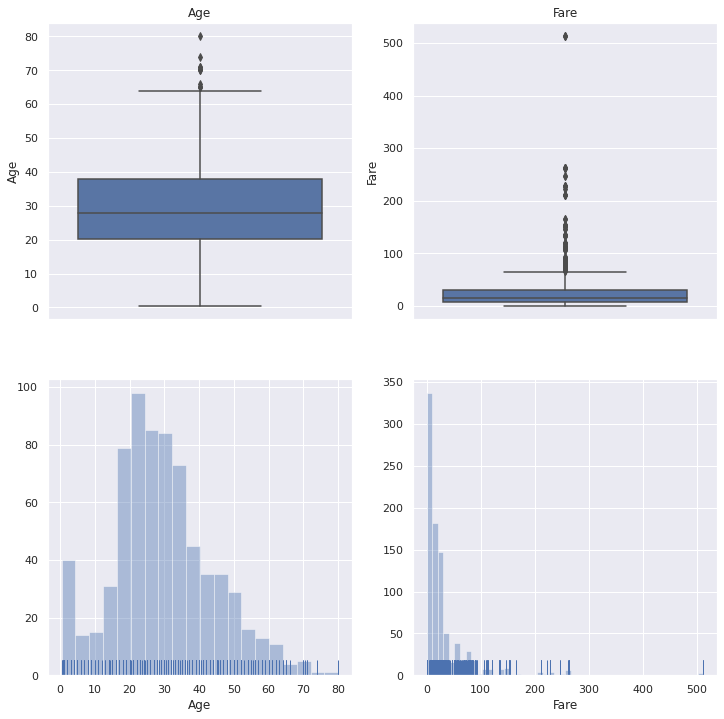

In [64]:
sns.set()
fig, axes=plt.subplots(2,2,figsize=(12,12))
sns.boxplot(y=train['Age'], ax=axes[0,0])
axes[0,0].set(title='Age')
sns.boxplot(y=train['Fare'], ax=axes[0,1])
axes[0,1].set(title='Fare')
sns.distplot(train['Age'], bins=20, kde=False, rug=True, ax=axes[1,0])
sns.distplot(train['Fare'], bins=20, kde=False, rug=True, ax=axes[1,1])

**Some statistical methodologies can be used to detect the outlier points. Here, we mention 3 methods: Standard Deviation, Percentile and Interquartile Range (IQR). The common idea is that, any value beyond the predetermined range  can be considered as outlier:** 

-*Standard Deviation*: The range is 
           $$(Mean-A.Std, Mean+A.Std),$$
where $A$ is a parameter, and normally, we take $A=3$ as in the Normal Distribution.

-*IQR*: The range is determined by 
        $$(Q_{0.25}-1.5IQR, Q_{0.75}+1.5IQR),$$ 
where $Q_\alpha$ is defined by $P[x<Q_\alpha]=\alpha$.

-*Percentile*:  $(Q_{0.05}, Q_{0.95})$


### 2. How to remove Outliers
The ideal way to solve this probkem is to find out the reason of having these outliers and it depends on the reason of their occurrence. Causes of outliers can be classified in two broad categories:

1. Artificial (Non-natural):  As the missing values, we can impute the outlier. 

2. Natural: Using the transformation.


### 2.1 Imputations
We treat as the missing values

In [65]:
class outlier:
    def __init__(self, data, cols):
        self.data=data
        self.cols=cols
    ######### Standard
    def Std(self):
        data=self.data.copy()
        mean=self.data[self.cols].mean()
        std=self.data[self.cols].std()
        for col in self.cols:
            data.loc[(data[col]<mean[col]-3*std[col])|(data[col]> mean[col]+3*std[col]), col]=mean[col]
        return data
    ###############Interquartile range
    def IQR(self):
        data=self.data.copy()
        for col in self.cols:
            q1, q2, q3=self.data[col].quantile([0.25, 0.5, 0.75])
            data.loc[(data[col]<2.5*q1-q3)|(data[col]> 2.5*q3-q1), col]=q2
        return data
    ################## Percentile
    def Percentile(self):
        data=self.data.copy()
        for col in self.cols:
            mean=self.data.mean()
            q1, q3=self.data[col].quantile([0.05, 0.95])
            data.loc[(data[col]<q1)|(data[col]> q3), col]=mean
        return data
    #################        

In [66]:
sns.set()
def compare_plot(before, after):
    fig, axes=plt.subplots(4,2,figsize=(10,18))
    sns.boxplot(y=before['Age'], ax=axes[0,0])
    axes[0,0].set(title='Before')
    sns.boxplot(y=after['Age'], ax=axes[0,1])
    axes[0,1].set(title='After')
    sns.distplot(before['Age'], kde=False, bins=20, ax=axes[1,0])
    sns.distplot(after['Age'],  kde=False, bins=20, ax=axes[1,1])
    sns.boxplot(y=before['Fare'], ax=axes[2,0])
    sns.boxplot(y=after['Fare'], ax=axes[2,1])
    sns.distplot(before['Fare'], kde=False, bins=20, ax=axes[3,0])
    sns.distplot(after['Fare'],  kde=False, bins=20, ax=axes[3,1])

In [67]:
train_outlier=outlier(train, ['Age', 'Fare'])

**Standard detection**

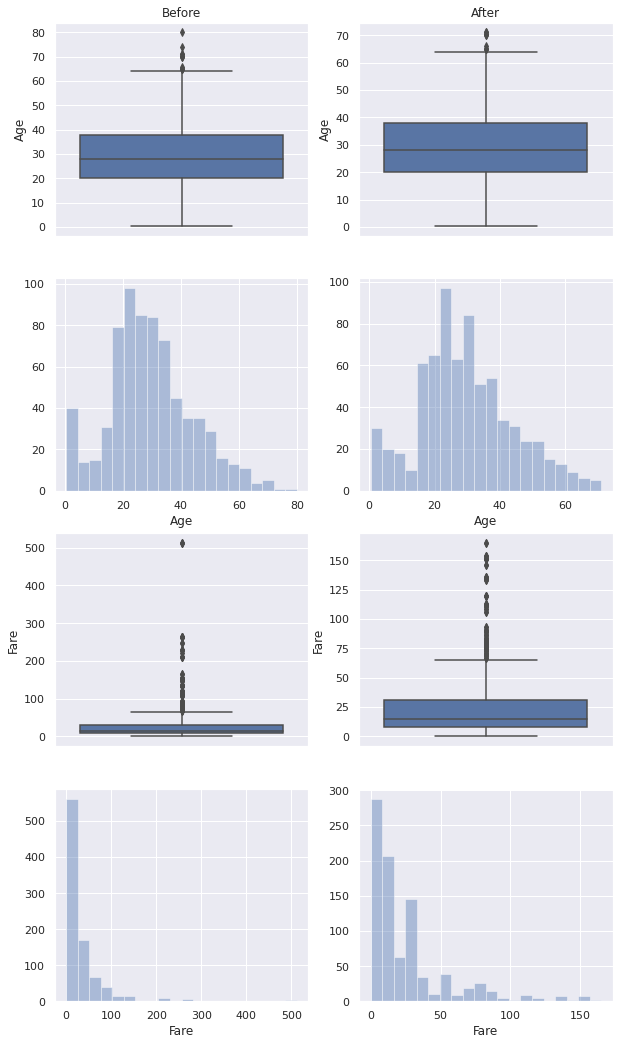

In [68]:
train_std=train_outlier.Std()
compare_plot(train, train_std)

**IQR detection**

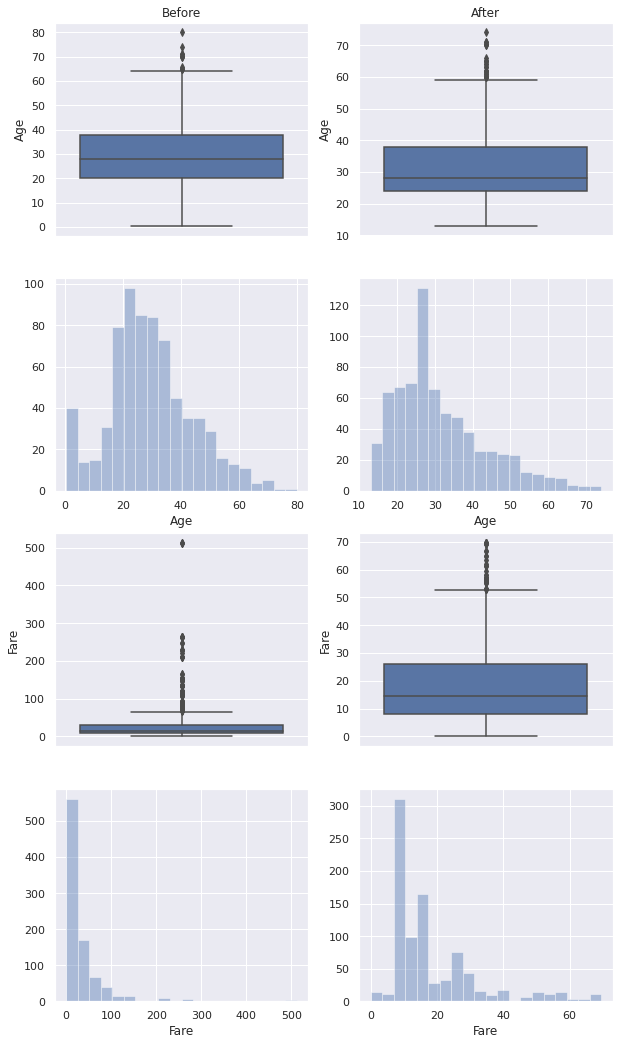

In [69]:
# IQR detection
train_iqr=train_outlier.IQR()
compare_plot(train, train_iqr )

**Percentile Detection**

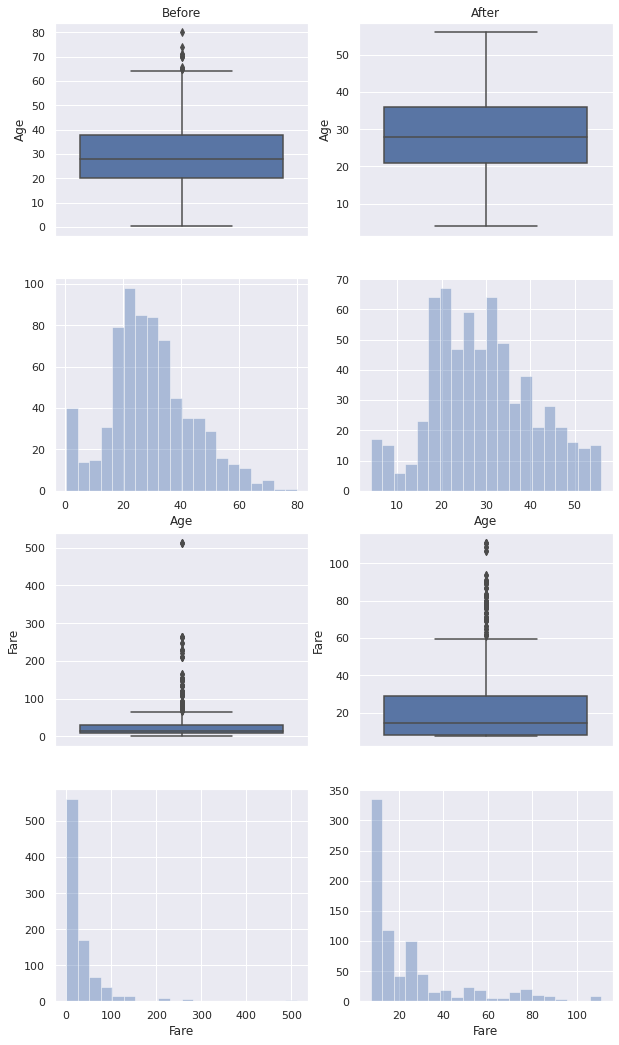

In [70]:
#Percentile Detection
train_per=train_outlier.Percentile()
compare_plot(train, train_per)

### 2.2 Transformations

**Logarit Transform**
        
**QuantileTransforme** 

-Sorting the sample X from the smallest to the largest observation: $x_1, \cdots , x_n.$

-Transforming each observation $x_i$ into observation $y_i= Q^{−1} (p_i)$ of the standard normal variate $Y$, with Q denoting the standard normal distribution and $p_i=P[X<x_i]$.

**PowerTransformer**

Using the Maximum Likelihood estimation to transform any distribution to as close to a normal distribution as possible. There are $2$ options: 'yeo-johnson' or 'box-cox'.
        

In [71]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
################# Transformations
class Trans_outlier():
    def __init__(self, data, cols):
        self.data=data
        self.cols=cols
    ####Logarit
    def Log_trans(self):
        data=self.data.copy()
        min_=self.data[self.cols].min()
        data[self.cols]=np.log1p(data[self.cols]-min_)
        return data
    #######Quantile transformer
    def Quant_trans(self):
        data=self.data.copy()
        quant_trans=QuantileTransformer(output_distribution='normal', random_state=10)
        quant_trans.fit(data[self.cols])
        data[self.cols]=quant_trans.transform(data[self.cols])
        return data
    ######## Power transformer
    def Power_trans(self, method):
        data=self.data.copy()
        quant_trans=PowerTransformer(method=method)
        quant_trans.fit(data[self.cols])
        data[self.cols]=quant_trans.transform(data[self.cols])
        return data    

In [72]:
trans_out=Trans_outlier(train, ['Age', 'Fare'])

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (891). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


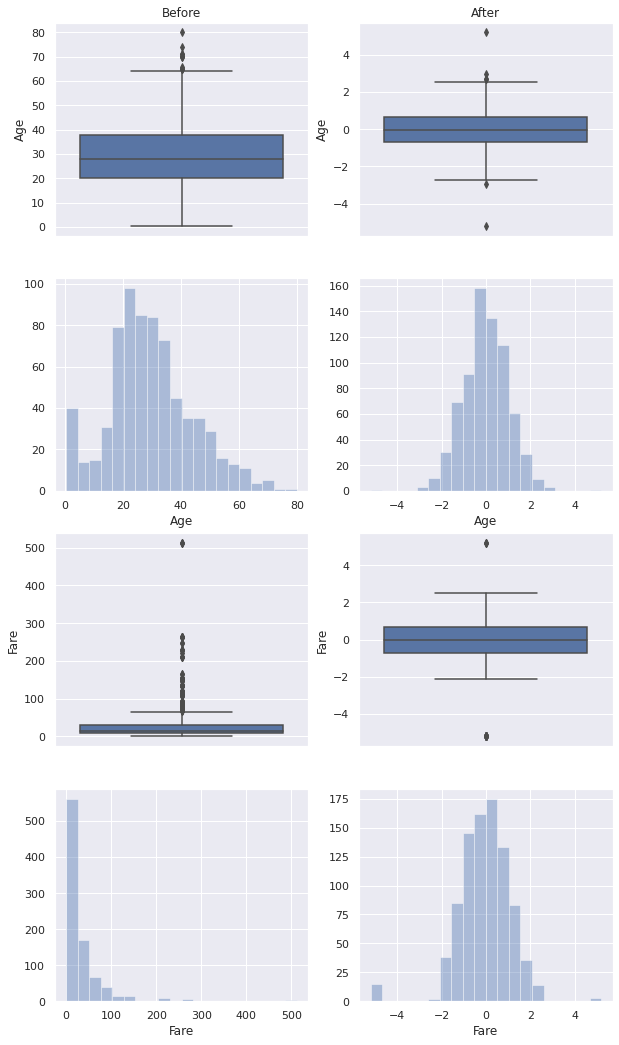

In [73]:
train_quant=trans_out.Quant_trans()
compare_plot(train, train_quant)

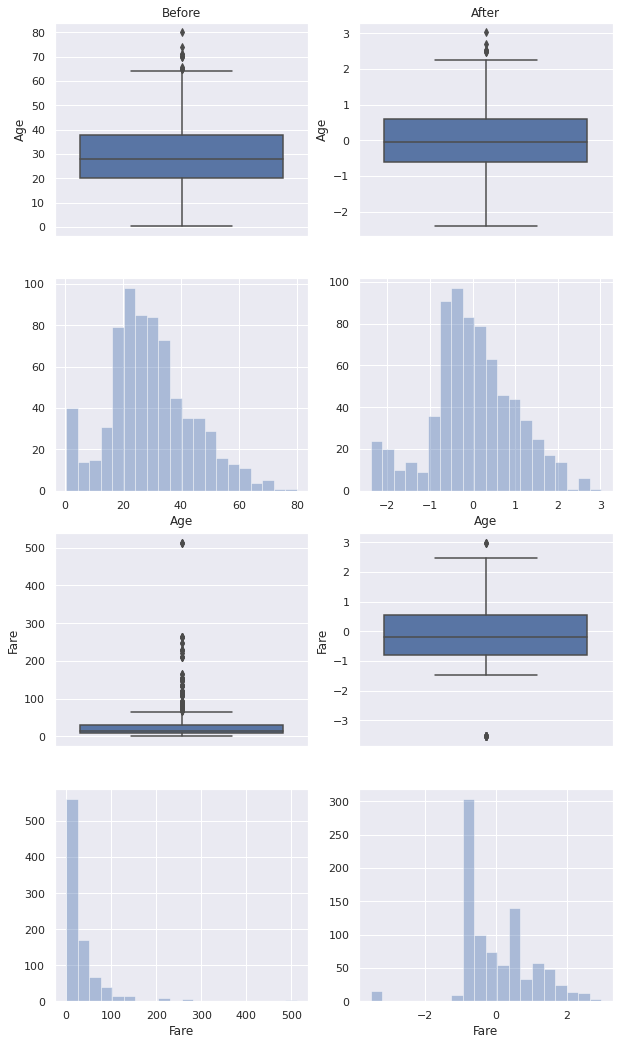

In [74]:
train_pow=trans_out.Power_trans('yeo-johnson')
compare_plot(train, train_pow)

In [75]:
des=train[['Age', 'Fare']]
des[['Age_Std', 'Fare_Std']]=train_std[['Age', 'Fare']]
des[['Age_IQR', 'Fare_IQR']]=train_iqr[['Age', 'Fare']]
des[['Age_Per', 'Fare_Per']]=train_per[['Age', 'Fare']]
des[['Age_Quant', 'Fare_Quant']]=train_quant[['Age', 'Fare']]
des[['Age_Pow', 'Fare_Pow']]=train_pow[['Age', 'Fare']]

#des[['Age_Trans', 'Fare_Trans']]=train_trans[['Age', 'Fare']]
des.describe()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Age,Fare,Age_Std,Fare_Std,Age_IQR,Fare_IQR,Age_Per,Fare_Per,Age_Quant,Fare_Quant,Age_Pow,Fare_Pow
count,714.000000,891.000000,714.000000,891.000000,714.000000,891.000000,649.000000,803.000000,714.000000,891.000000,7.140000e+02,8.910000e+02
mean,29.699118,32.204208,29.566622,26.657534,31.871148,18.056634,29.184129,24.242662,0.000294,-0.039095,-2.643388e-18,3.379265e-16
std,14.526497,49.693429,14.307353,29.031704,11.907759,13.927137,11.537395,22.508849,1.027908,1.188241,1.000701e+00,1.000562e+00
min,0.420000,0.000000,0.420000,0.000000,13.000000,0.000000,4.000000,7.225000,-5.199338,-5.199338,-2.394799e+00,-3.534079e+00
25%,20.125000,7.910400,20.125000,7.910400,24.000000,7.910400,21.000000,8.050000,-0.697794,-0.694942,-6.087862e-01,-7.919073e-01
50%,28.000000,14.454200,28.000000,14.454200,28.000000,14.454200,28.000000,14.454200,-0.026759,-0.005633,-5.183492e-02,-1.891020e-01
75%,38.000000,31.000000,38.000000,31.000000,38.000000,25.927100,36.000000,29.125000,0.658663,0.670958,6.050169e-01,5.594584e-01
max,80.000000,512.329200,71.000000,164.866700,74.000000,69.550000,56.000000,110.883300,5.199338,5.199338,3.022690e+00,2.971192e+00
